In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# We get a lot of warnings about slices of copies, these are not meaningful.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define our source files
COVID_file = 'COVID_by_County/COVID_by_County.csv'
pop_file = 'popData.csv'
US_county_land_file = 'LND01.csv'
US_county_vote_file = 'president_county_candidate.csv'
mask_use_file = '../covid-19-data/mask-use/mask-use-by-county.csv'

# Read the source files into dataframes.
COVID_data = pd.read_csv(COVID_file)
pop_data = pd.read_csv(pop_file)
land_data = pd.read_csv(US_county_land_file)
vote_data = pd.read_csv(US_county_vote_file)
mask_use = pd.read_csv(mask_use_file)

In [3]:
# Rename some of the columns
COVID_data = COVID_data.rename(columns={'countyFIPS':'fips'})
pop_data = pop_data.rename(columns={'FIPS':'fips', 'Poverty Percent':'Poverty_pct'})
land_data = land_data.rename(columns={'STCOU':'fips','LND010190D':'land'})

# We don't need most of this dataframe so we truncate it down.
land_data = land_data[['fips','land']]

# the vote data is stores as a mixture of row and column data so we jump through hoops to make it usable.
Biden = vote_data[vote_data.candidate == 'Joe Biden']
trump = vote_data[vote_data.candidate == 'Donald Trump']
vote_data = Biden[['state', 'county', 'total_votes']].copy()
vote_data.rename(columns={'total_votes':'Biden'}, inplace=True)
vote_data['Trump'] = trump.total_votes.to_numpy()

# We need some definition that allows us to compare to similar categories.
mask_use['mask_pct'] = mask_use['FREQUENTLY'] + mask_use['ALWAYS']

# merge the vote data into the populationm data, we can't do this on the main dataframe DF because vote data does not use fips.
pop_data = pd.merge(pop_data, vote_data, left_on = ['CTYNAME', 'STNAME'], right_on = ['county','state'])

In [4]:
# Merge all the datasets into one main dataframe, DF.  Fioltering down when necessary.
DF = pd.merge(COVID_data, pop_data[['fips', 'POPESTIMATE2018', 'Poverty_pct', 'Biden', 'Trump']], left_on='fips', right_on='fips')
DF = pd.merge(DF,land_data,  left_on='fips', right_on='fips')
DF = pd.merge(DF, mask_use[['COUNTYFP','mask_pct']], left_on = 'fips', right_on = 'COUNTYFP')

# We need to make sure the poverty data is converted from an object type.
DF.Poverty_pct = DF.Poverty_pct.astype('float')

# We don't need NaN entries, they will only cause issues.
DF = DF.dropna()

# write out the dataframe to check.
DF

,Dates,fips,County Name,State,cases,deaths,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct
0,1/22/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
1,1/23/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
2,1/24/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
3,1/25/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
4,1/26/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
...,...,...,...,...,...,...,...,...,...,...,...,...,...
982884,12/5/2020,56045,Weston County,WY,419,2,6924,11.8,360,3107,2400.13,56045,0.581
982885,12/6/2020,56045,Weston County,WY,420,2,6924,11.8,360,3107,2400.13,56045,0.581
982886,12/7/2020,56045,Weston County,WY,422,2,6924,11.8,360,3107,2400.13,56045,0.581
982887,12/8/2020,56045,Weston County,WY,425,2,6924,11.8,360,3107,2400.13,56045,0.581


In [5]:
# Need to fix some counties that have 0 area in the dataset, data manually found with Google.
DF.land[DF['County Name'] == 'Broomfield County and City'] = 33.55
DF.land[DF['County Name'] == 'Yakutat City and Borough'] = 9463
DF.land[DF['County Name'] == 'Denali Borough'] = 12777
DF.land[DF['County Name'] == 'Skagway Municipality'] = 464
DF.land[DF['County Name'] == 'Wrangell City and Borough'] = 3477

# We create new columns containing per capita data
DF['cases_per_100k'] = DF.cases / DF.POPESTIMATE2018 * 100000
DF['deaths_per_100k'] = DF.deaths / DF.POPESTIMATE2018 * 100000
DF['pop_density'] = DF.POPESTIMATE2018 / DF.land
DF['Biden_per_100k'] = DF.Biden /DF.POPESTIMATE2018 * 100000
DF['Trump_per_100k'] = DF.Trump /DF.POPESTIMATE2018 * 100000
DF

,Dates,fips,County Name,State,cases,deaths,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct,cases_per_100k,deaths_per_100k,pop_density,Biden_per_100k,Trump_per_100k
0,1/22/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
1,1/23/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
2,1/24/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
3,1/25/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
4,1/26/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982884,12/5/2020,56045,Weston County,WY,419,2,6924,11.8,360,3107,2400.13,56045,0.581,6051.415367,28.885038,2.884844,5199.306759,44872.905835
982885,12/6/2020,56045,Weston County,WY,420,2,6924,11.8,360,3107,2400.13,56045,0.581,6065.857886,28.885038,2.884844,5199.306759,44872.905835
982886,12/7/2020,56045,Weston County,WY,422,2,6924,11.8,360,3107,2400.13,56045,0.581,6094.742923,28.885038,2.884844,5199.306759,44872.905835
982887,12/8/2020,56045,Weston County,WY,425,2,6924,11.8,360,3107,2400.13,56045,0.581,6138.070479,28.885038,2.884844,5199.306759,44872.905835


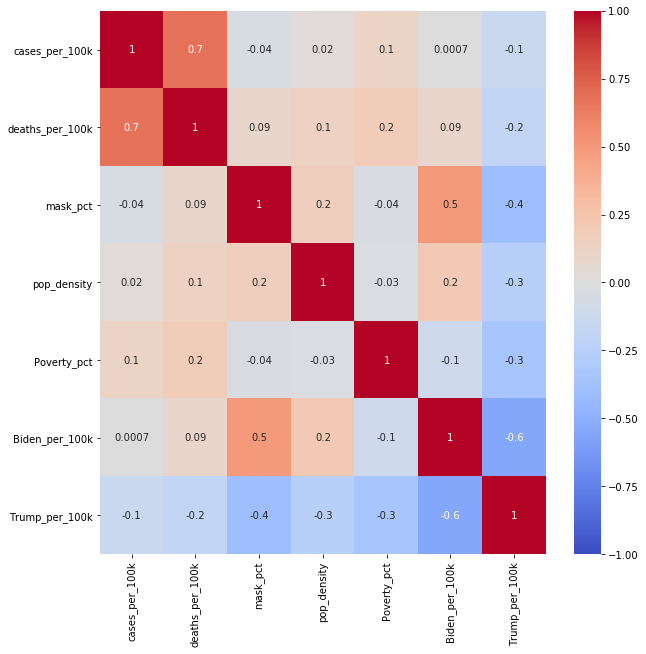

In [6]:
# Print a heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(DF[['cases_per_100k','deaths_per_100k','mask_pct','pop_density','Poverty_pct','Biden_per_100k','Trump_per_100k']].corr(), annot = True, fmt = '0.1g', cmap = 'coolwarm', vmin=-1)

In [7]:
# Create some very macabre fits.
deaths_fit = sm.OLS(DF['deaths_per_100k'],sm.add_constant(DF[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']])).fit()

print(deaths_fit.summary())

                            OLS Regression Results                            
Dep. Variable:        deaths_per_100k   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                 1.435e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        14:27:40   Log-Likelihood:            -5.1283e+06
No. Observations:              982889   AIC:                         1.026e+07
Df Residuals:                  982883   BIC:                         1.026e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.6592      0.492     -1.

In [8]:
cases_fit = sm.OLS(DF['cases_per_100k'],sm.add_constant(DF[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']])).fit()

print(cases_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         cases_per_100k   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     6908.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        14:27:40   Log-Likelihood:            -8.7159e+06
No. Observations:              982889   AIC:                         1.743e+07
Df Residuals:                  982883   BIC:                         1.743e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2946.6922     18.943    155.

In [9]:
# Create a reduced data frame with just one time slice.
RDF = DF[DF['Dates'] == '12/9/2020']
RDF

,Dates,fips,County Name,State,cases,deaths,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct,cases_per_100k,deaths_per_100k,pop_density,Biden_per_100k,Trump_per_100k
322,12/9/2020,1001,Autauga County,AL,3117,42,55533,13.8,7503,19838,604.49,1001,0.739,5612.878829,75.630706,91.867525,13510.885419,35722.903499
645,12/9/2020,1003,Baldwin County,AL,10087,141,217855,9.8,24578,83544,2027.08,1003,0.759,4630.143903,64.721948,107.472325,11281.815887,38348.442772
968,12/9/2020,1005,Barbour County,AL,1245,30,24872,30.9,4816,5622,904.59,1005,0.692,5005.628820,120.617562,27.495329,19363.139273,22603.731103
1291,12/9/2020,1007,Bibb County,AL,1322,39,22367,21.8,1986,7525,625.50,1007,0.850,5910.493137,174.364018,35.758593,8879.152323,33643.313811
1614,12/9/2020,1009,Blount County,AL,3496,47,57771,13.2,2640,24711,650.65,1009,0.653,6051.479116,81.355697,88.789672,4569.766838,42774.056187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981596,12/9/2020,56037,Sweetwater County,WY,2245,13,42858,8.4,3823,12229,10491.73,56037,0.414,5238.228569,30.332727,4.084932,8920.154930,28533.762658
981919,12/9/2020,56039,Teton County,WY,1834,2,23269,6.3,9848,4341,4221.96,56039,0.587,7881.731058,8.595127,5.511421,42322.403197,18655.722206
982242,12/9/2020,56041,Uinta County,WY,1250,7,20292,10.0,1591,7496,2087.66,56041,0.471,6160.063079,34.496353,9.719974,7840.528287,36940.666272
982565,12/9/2020,56043,Washakie County,WY,586,11,7877,11.9,651,3245,2242.85,56043,0.572,7439.380475,139.647074,3.512049,8264.567729,41195.886759


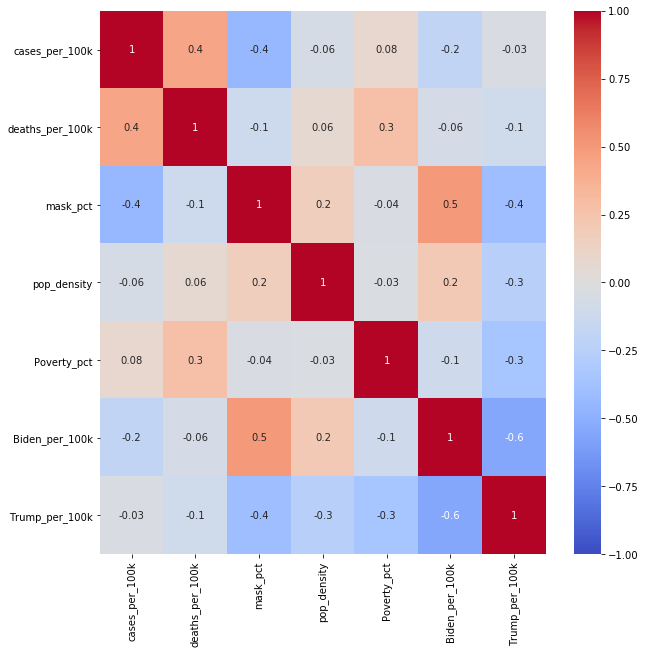

In [10]:
# Print a heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(RDF[['cases_per_100k','deaths_per_100k','mask_pct','pop_density','Poverty_pct','Biden_per_100k','Trump_per_100k']].corr(), annot = True, fmt = '0.1g', cmap = 'coolwarm', vmin=-1)

In [11]:
# Create some very macabre fits.
deaths_fit = sm.OLS(RDF['deaths_per_100k'],sm.add_constant(RDF[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']])).fit()

print(deaths_fit.summary())

                            OLS Regression Results                            
Dep. Variable:        deaths_per_100k   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     64.07
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           9.74e-64
Time:                        14:27:41   Log-Likelihood:                -17339.
No. Observations:                3043   AIC:                         3.469e+04
Df Residuals:                    3037   BIC:                         3.473e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            109.0943     14.317      7.

In [12]:
cases_fit = sm.OLS(RDF['cases_per_100k'],sm.add_constant(RDF[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']])).fit()

print(cases_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         cases_per_100k   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     212.3
Date:                Mon, 14 Dec 2020   Prob (F-statistic):          1.15e-194
Time:                        14:27:41   Log-Likelihood:                -27700.
No. Observations:                3043   AIC:                         5.541e+04
Df Residuals:                    3037   BIC:                         5.545e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.649e+04    431.086     38.

In [13]:
mask = RDF['State'] == 'FL'

RDF_train = RDF[~mask]
RDF_test = RDF[mask]

In [14]:
RDF_train

,Dates,fips,County Name,State,cases,deaths,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct,cases_per_100k,deaths_per_100k,pop_density,Biden_per_100k,Trump_per_100k
322,12/9/2020,1001,Autauga County,AL,3117,42,55533,13.8,7503,19838,604.49,1001,0.739,5612.878829,75.630706,91.867525,13510.885419,35722.903499
645,12/9/2020,1003,Baldwin County,AL,10087,141,217855,9.8,24578,83544,2027.08,1003,0.759,4630.143903,64.721948,107.472325,11281.815887,38348.442772
968,12/9/2020,1005,Barbour County,AL,1245,30,24872,30.9,4816,5622,904.59,1005,0.692,5005.628820,120.617562,27.495329,19363.139273,22603.731103
1291,12/9/2020,1007,Bibb County,AL,1322,39,22367,21.8,1986,7525,625.50,1007,0.850,5910.493137,174.364018,35.758593,8879.152323,33643.313811
1614,12/9/2020,1009,Blount County,AL,3496,47,57771,13.2,2640,24711,650.65,1009,0.653,6051.479116,81.355697,88.789672,4569.766838,42774.056187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981596,12/9/2020,56037,Sweetwater County,WY,2245,13,42858,8.4,3823,12229,10491.73,56037,0.414,5238.228569,30.332727,4.084932,8920.154930,28533.762658
981919,12/9/2020,56039,Teton County,WY,1834,2,23269,6.3,9848,4341,4221.96,56039,0.587,7881.731058,8.595127,5.511421,42322.403197,18655.722206
982242,12/9/2020,56041,Uinta County,WY,1250,7,20292,10.0,1591,7496,2087.66,56041,0.471,6160.063079,34.496353,9.719974,7840.528287,36940.666272
982565,12/9/2020,56043,Washakie County,WY,586,11,7877,11.9,651,3245,2242.85,56043,0.572,7439.380475,139.647074,3.512049,8264.567729,41195.886759


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C149A3EAC8>,
      dtype=object)

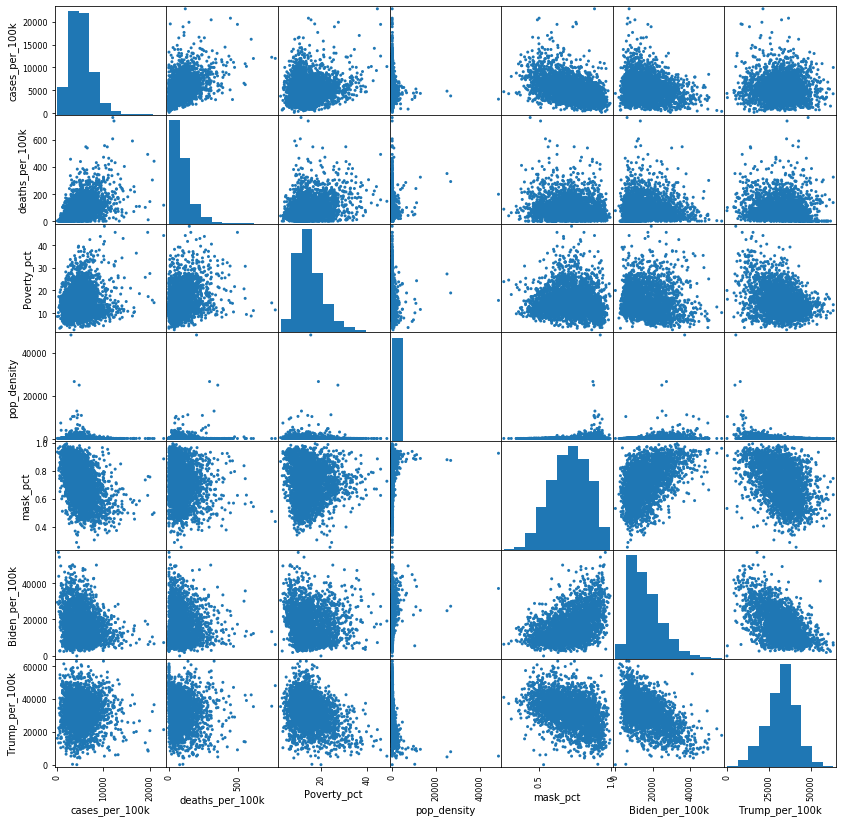

In [15]:
pd.plotting.scatter_matrix(RDF[['cases_per_100k','deaths_per_100k','Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']], figsize = (14,14), alpha = 1)

In [16]:
regr_c = RandomForestRegressor(max_depth = 40)

In [17]:
X_train = RDF_train[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']]
y_cases_train = RDF_train['cases_per_100k']
y_deaths_train = RDF_train['deaths_per_100k']

X_test = RDF_test[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']]
y_cases_test = RDF_test['cases_per_100k']
y_deaths_test = RDF_test['deaths_per_100k']

In [18]:
regr_c.fit(X_train, y_cases_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

[Text(0, 0, 'Alachua County'),
 Text(0, 0, 'Baker County'),
 Text(0, 0, 'Bay County'),
 Text(0, 0, 'Bradford County'),
 Text(0, 0, 'Brevard County'),
 Text(0, 0, 'Broward County'),
 Text(0, 0, 'Calhoun County'),
 Text(0, 0, 'Charlotte County'),
 Text(0, 0, 'Citrus County'),
 Text(0, 0, 'Clay County'),
 Text(0, 0, 'Collier County'),
 Text(0, 0, 'Columbia County'),
 Text(0, 0, 'DeSoto County'),
 Text(0, 0, 'Dixie County'),
 Text(0, 0, 'Duval County'),
 Text(0, 0, 'Escambia County'),
 Text(0, 0, 'Flagler County'),
 Text(0, 0, 'Franklin County'),
 Text(0, 0, 'Gadsden County'),
 Text(0, 0, 'Gilchrist County'),
 Text(0, 0, 'Glades County'),
 Text(0, 0, 'Gulf County'),
 Text(0, 0, 'Hamilton County'),
 Text(0, 0, 'Hardee County'),
 Text(0, 0, 'Hendry County'),
 Text(0, 0, 'Hernando County'),
 Text(0, 0, 'Highlands County'),
 Text(0, 0, 'Hillsborough County'),
 Text(0, 0, 'Holmes County'),
 Text(0, 0, 'Indian River County'),
 Text(0, 0, 'Jackson County'),
 Text(0, 0, 'Jefferson County'),
 Text(

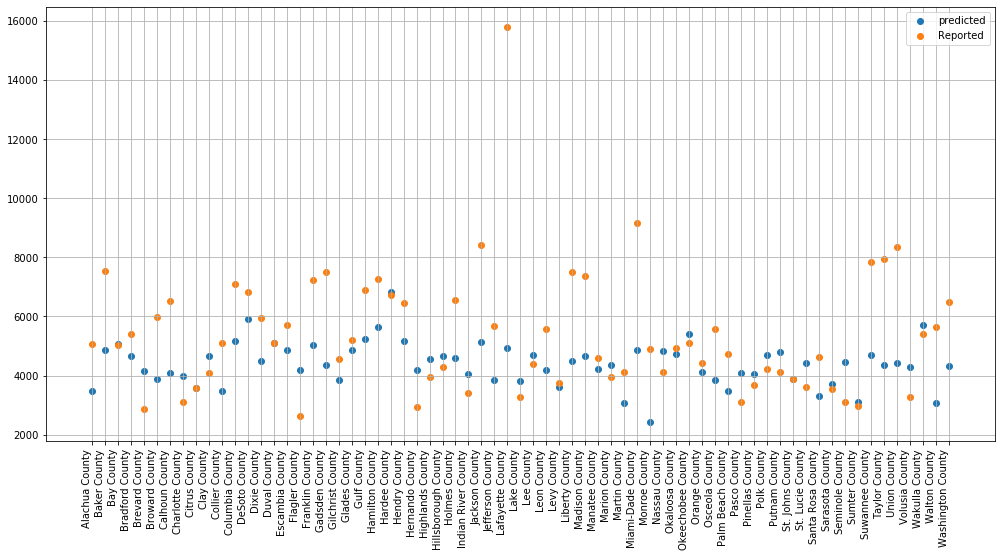

In [36]:
fix, ax = plt.subplots(1,1, figsize=(17,8))

ax.scatter(RDF_test['County Name'], regr_c.predict(X_test), label = 'predicted')
ax.scatter(RDF_test['County Name'], y_cases_test, label = 'Reported')
ax.legend()
ax.grid(True)
ax.set_xticklabels(RDF_test['County Name'], rotation=90, ha='right')

In [20]:
regr_d = RandomForestRegressor(max_depth = 40)
regr_d.fit(X_train, y_deaths_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

[Text(0, 0, 'Alachua County'),
 Text(0, 0, 'Baker County'),
 Text(0, 0, 'Bay County'),
 Text(0, 0, 'Bradford County'),
 Text(0, 0, 'Brevard County'),
 Text(0, 0, 'Broward County'),
 Text(0, 0, 'Calhoun County'),
 Text(0, 0, 'Charlotte County'),
 Text(0, 0, 'Citrus County'),
 Text(0, 0, 'Clay County'),
 Text(0, 0, 'Collier County'),
 Text(0, 0, 'Columbia County'),
 Text(0, 0, 'DeSoto County'),
 Text(0, 0, 'Dixie County'),
 Text(0, 0, 'Duval County'),
 Text(0, 0, 'Escambia County'),
 Text(0, 0, 'Flagler County'),
 Text(0, 0, 'Franklin County'),
 Text(0, 0, 'Gadsden County'),
 Text(0, 0, 'Gilchrist County'),
 Text(0, 0, 'Glades County'),
 Text(0, 0, 'Gulf County'),
 Text(0, 0, 'Hamilton County'),
 Text(0, 0, 'Hardee County'),
 Text(0, 0, 'Hendry County'),
 Text(0, 0, 'Hernando County'),
 Text(0, 0, 'Highlands County'),
 Text(0, 0, 'Hillsborough County'),
 Text(0, 0, 'Holmes County'),
 Text(0, 0, 'Indian River County'),
 Text(0, 0, 'Jackson County'),
 Text(0, 0, 'Jefferson County'),
 Text(

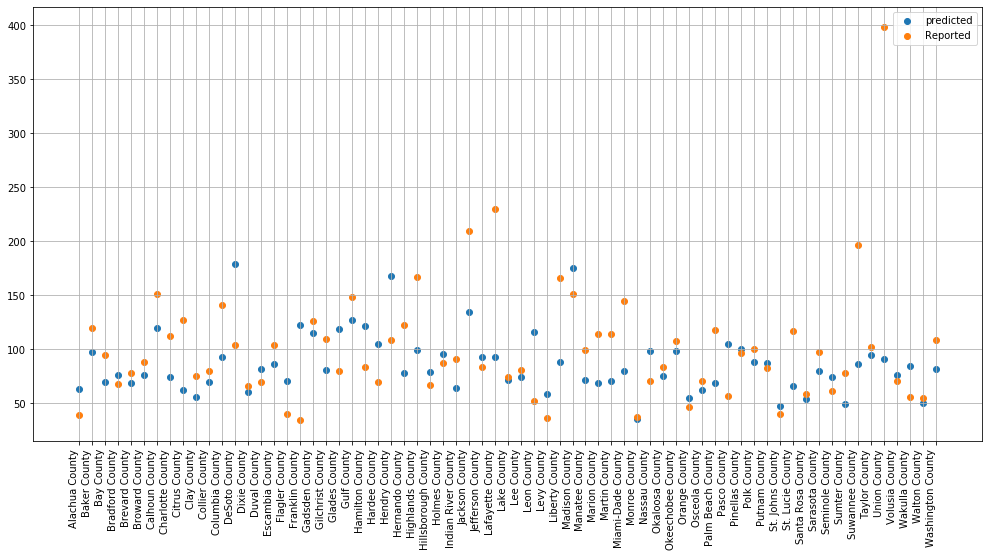

In [33]:
fix, ax = plt.subplots(1,1, figsize=(17,8))

ax.scatter(RDF_test['County Name'], regr_d.predict(X_test), label = 'predicted')
ax.scatter(RDF_test['County Name'], y_deaths_test, label = 'Reported')
ax.legend()
ax.grid(True)
ax.set_xticklabels(RDF_test['County Name'], rotation=90, ha='right')